# Homogenous Quantum Turbulence
Here I am trying to implement a simple mode of quantum vertex based on my very imcomplete understanding and poor insight.

In [114]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)
from mmfutils.contexts import NoInterrupt
from imp import reload  # Python 3.0 - 3.3
import numpy as np
import scipy.integrate
import scipy as sp
from collections import namedtuple

<IPython.core.display.Javascript object>

## Regularization
For dD homogenous case, I will use the relatin between the scattering length and the effective potential strength:
$$
\frac{8\pi}{g_e}=\frac{2}{a} - \frac{4k_c}{\pi}
$$

where $g_e(k_c)$ is a function depends on $k_c$

In [115]:
import homogeneous;reload(homogeneous)
h = homogeneous.Homogeneous1D()
delta = 1.0
mu_eff = 1.0
m = 1.0
hbar = 1.0
mus_eff = [mu_eff]*2
v_0, (na, nb), (mua, mub) = h.get_BCS_v_n_e(delta=delta, mus_eff=mus_eff)
v_0_, n_, mu_, e_0_ = homogeneous.get_BCS_v_n_e(delta=delta, mu_eff=mu_eff)
assert np.allclose([v_0, na+nb, (mua+mub)/2], [v_0_, n_, mu_])

### BCS Code

In [116]:
def quad(f, kF=None, k_0=0, k_inf=np.inf, limit=1000):
    """Wrapper for quad that deals with singularities
    at the Fermi surface.
    """
    if kF is None:
        res, err = sp.integrate.quad(f, k_0, k_inf)
    else:
        # One might think that `points=[kF]` could be used here, but
        # this does not work with infinite limits.
        res0, err0 = sp.integrate.quad(f, k_0, kF)
        res1, err1 = sp.integrate.quad(f, kF, k_inf, limit=limit)
        res = res0 + res1
        err = max(err0, err1)
    
    if abs(err) > 1e-6 and abs(err/res) > 1e-6:
        warnings.warn(
            "Gap integral did not converge: res, err = %g, %g" % (res, err))
    return 2*res   # Accounts for integral from -inf to inf

def get_BCS_v_n_e(delta, mu_eff):
    m = hbar = 1.0
    kF = np.sqrt(2*m*max(0, mu_eff))/hbar

    def gap_integrand(k):
        e_p = (hbar*k)**2/2.0/m - mu_eff
        return 1./np.sqrt(e_p**2 + abs(delta)**2)
    
    v_0 = 4*np.pi / quad(gap_integrand, kF)

    def n_integrand(k):
        """Density"""
        e_p = (hbar*k)**2/2.0/m - mu_eff
        denom = np.sqrt(e_p**2 + abs(delta)**2)
        return (denom - e_p)/denom

    n = quad(n_integrand, kF) / 2/np.pi

    def e_integrand(k):
        """Energy"""
        e_p = (hbar*k)**2/2.0/m - mu_eff
        denom = np.sqrt(e_p**2 + abs(delta)**2)
        return (hbar*k)**2/2.0/m * (denom - e_p)/denom
    e = quad(e_integrand, kF) / 2/np.pi - v_0*n**2/4.0 - abs(delta)**2/v_0

    mu = mu_eff - n*v_0/2

    return namedtuple('BCS_Results', ['v_0', 'n', 'mu', 'e'])(v_0, n, mu, e)

def get_scattering_lenght(delta, mu_eff, k_c):
    def f(k):
        e_p = (hbar*k)**2/2.0/m - mu_eff
        return 1./np.sqrt(e_p**2 + abs(delta)**2)
    res, err = sp.integrate.quad(f, 0, k_c)
    if abs(err) > 1e-6 and abs(err/res) > 1e-6:
        warnings.warn(
            "Gap integral did not converge: res, err = %g, %g" % (res, err))
    a = 2.0/(-4.0*np.pi * 2.0 * res + 4 * k_c/np.pi)
    return a
    

def BCS(mu_eff, delta=1.0):
    m = hbar = 1.0
    v_0, n, mu, e = get_BCS_v_n_e(delta=delta, mu_eff=mu_eff)
    lam = m*v_0/n/hbar**2
    # Energy per-particle
    E_N = e/n
    # Energy per-particle for 2 particles
    E_2 = -m*v_0**2/4.0 / 2.0
    E_N_E_2 = E_N/abs(E_2)
    return E_N_E_2, lam


## Test Regularization for 1D

In [117]:
delta, mu_eff = np.random.random(2)

In [118]:
g_0, n,mu,e = get_BCS_v_n_e(delta, mu_eff)

We have the $g_0$ and the gap $\Delta$ now, we can test if the regularizaion works. 
$$
  \frac{8\pi}{g_2} = \frac{2}{a} - \frac{4k_c}{\pi} = -\frac{8\pi}{2}\int\frac{\d{k}^3}{(2\pi)^3}\;\frac{1}{\sqrt{\epsilon_+^2 + \Delta^2}}.\\
  \frac{2}{a}  = -\frac{8\pi}{2}\int\frac{\d{k}^3}{(2\pi)^3}\;\frac{1}{\sqrt{\epsilon_+^2 + \Delta^2}} +\frac{4k_c}{\pi}
$$

0.000645131601334854


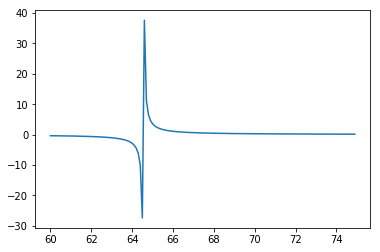

In [131]:
import matplotlib.pyplot as plt
print(get_scattering_lenght(delta, mu_eff, 2500.))
k_s = np.arange(60,75,0.1)
a_s = [ get_scattering_lenght(delta, mu_eff, k) for k in k_s]
plt.plot(k_s,a_s)

OK, I am such a dumb, this is not working here as the relation is for 3D.

In [134]:
print(get_scattering_lenght(delta, mu_eff, 250.))
print(get_scattering_lenght(delta, mu_eff, 350.))

0.008491319888181895
0.005512661676142727
